In [2]:
import numpy as np # for Array 
import pandas as pd # for DataFrames
import matplotlib.pyplot as plt # to plot


# Analysis MTL-Approach

In this analysis, we create Table 3.2 in which we show the MTL performance evaluation using in vitro datasets. 

### Table 3.2

In [ ]:
# Analysis by MSE and Pearson Correlation 

# Load Baseline Modell
task_mses = pd.read_csv("./results/MTL/Baseline/mean_metrics_per_task_baseline.csv", index_col=0)

# Load Gene-Drug-Interaction
task_mses_direct =  pd.read_csv("./results/MTL/DGI/new/mean_metrics_per_task_direct.csv", index_col=0)
task_mses_indirect_02 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_02.csv", index_col=0)
task_mses_indirect_03 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_03.csv", index_col=0)
task_mses_indirect_04 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_04.csv", index_col=0)
task_mses_indirect_05 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_05.csv", index_col=0)
task_mses_indirect_06 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_06.csv", index_col=0)
task_mses_indirect_07 = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_indirect_07.csv", index_col=0)

task_mses_direct = task_mses_direct.rename(columns={ 'Mean_MSE': 'Mean_MSE_direct'})
task_mses_indirect_02 = task_mses_indirect_02.rename(columns={ 'Mean_MSE': 'Mean_MSE_02'})
task_mses_indirect_03 = task_mses_indirect_03.rename(columns={ 'Mean_MSE': 'Mean_MSE_03'})
task_mses_indirect_04 = task_mses_indirect_04.rename(columns={ 'Mean_MSE': 'Mean_MSE_04'})
task_mses_indirect_05 = task_mses_indirect_05.rename(columns={ 'Mean_MSE': 'Mean_MSE_05'})
task_mses_indirect_06 = task_mses_indirect_06.rename(columns={ 'Mean_MSE': 'Mean_MSE_06'})
task_mses_indirect_07 = task_mses_indirect_07.rename(columns={ 'Mean_MSE': 'Mean_MSE_07'})
task_mses_direct = task_mses_direct.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_direct'})
task_mses_indirect_02 = task_mses_indirect_02.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_02'})
task_mses_indirect_03 = task_mses_indirect_03.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_03'})
task_mses_indirect_04 = task_mses_indirect_04.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_04'})
task_mses_indirect_05 = task_mses_indirect_05.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_05'})
task_mses_indirect_06 = task_mses_indirect_06.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_06'})
task_mses_indirect_07 = task_mses_indirect_07.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_07'})

# Load Gene-Pathway-Interaction
task_mses_pathway = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_pathway.csv", index_col=0)
task_mses_pathway_count = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_pathway_count.csv", index_col=0)
task_mses_pathway_frequency = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_pathway_frequency.csv", index_col=0)
task_mses_pathway_weights = pd.read_csv("./results/MTL/DGI/mean_metrics_per_task_pathway_weights.csv", index_col=0)

task_mses_pathway = task_mses_pathway.rename(columns={ 'Mean_MSE': 'Mean_MSE_pathway'})
task_mses_pathway_count = task_mses_pathway_count.rename(columns={ 'Mean_MSE': 'Mean_MSE_pathway_count'})
task_mses_pathway_frequency = task_mses_pathway_frequency.rename(columns={ 'Mean_MSE': 'Mean_MSE_pathway_frequency'})
task_mses_pathway_weights = task_mses_pathway_weights.rename(columns={ 'Mean_MSE': 'Mean_MSE_pathway_weights'})

task_mses_pathway = task_mses_pathway.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_pathway'})
task_mses_pathway_count = task_mses_pathway_count.rename(columns={ 'Mean_Mean_PearsonMSE': 'Mean_Pearson_pathway_count'})
task_mses_pathway_frequency = task_mses_pathway_frequency.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_pathway_frequency'})
task_mses_pathway_weights = task_mses_pathway_weights.rename(columns={ 'Mean_Pearson': 'Mean_Pearson_pathway_weights'})

# Combine them
combined_df = pd.concat([
    task_mses,
    task_mses_direct,
    task_mses_indirect_02,
    task_mses_indirect_03,
    task_mses_indirect_04,
    task_mses_indirect_05,
    task_mses_indirect_06,
    task_mses_indirect_07,
    task_mses_pathway,
    task_mses_pathway_count,
    task_mses_pathway_frequency,
    task_mses_pathway_weights
], axis=1)

combined_df_median = combined_df.median()
print(combined_df_median)



Mean_MSE                          1.643601
Mean_Pearson                      0.510001
Mean_MSE_direct                   1.609756
Mean_Pearson_direct               0.536903
Mean_MSE_02                       1.554247
Mean_Pearson_02                   0.541706
Mean_MSE_03                       1.568814
Mean_Pearson_03                   0.541169
Mean_MSE_04                       1.548404
Mean_Pearson_04                   0.539937
Mean_MSE_05                       1.560695
Mean_Pearson_05                   0.540189
Mean_MSE_06                       1.563630
Mean_Pearson_06                   0.540523
Mean_MSE_07                       1.562381
Mean_Pearson_07                   0.540298
Mean_MSE_pathway                  1.575023
Mean_Pearson_pathway              0.537231
Mean_MSE_pathway_count            1.594914
Mean_Pearson                      0.540183
Mean_MSE_pathway_frequency        1.617008
Mean_Pearson_pathway_frequency    0.518323
Mean_MSE_pathway_weights          1.572233
Mean_Pearso

### Which drugs have the highest median MSE values?

In [6]:
# Choose them with the best MTL-Results
combined_df = combined_df[["Mean_MSE", "Mean_MSE_direct", "Mean_MSE_05", "Mean_MSE_pathway", "Mean_MSE_pathway_weights"]]

# Sort each column with Drugs with highest MSE
top_n = 9
top_drug_sets = []
for col in combined_df.columns:
    top_drugs = combined_df[col].nlargest(top_n).index
    top_drug_sets.append(set(top_drugs))

# Combine them and count the lowest MQF values per method (among the top N drugs)
all_top_drugs = set.union(*top_drug_sets)
df_top = combined_df.loc[list(all_top_drugs)]
df_top["Best_Method"] = df_top.idxmin(axis=1)
df_top = df_top.sort_index()
beste_methode_counts = df_top["Best_Method"].value_counts()
print(beste_methode_counts)



Best_Method
Mean_MSE_pathway_weights    2
Mean_MSE                    2
Mean_MSE_direct             2
Mean_MSE_pathway            2
Mean_MSE_05                 1
Name: count, dtype: int64


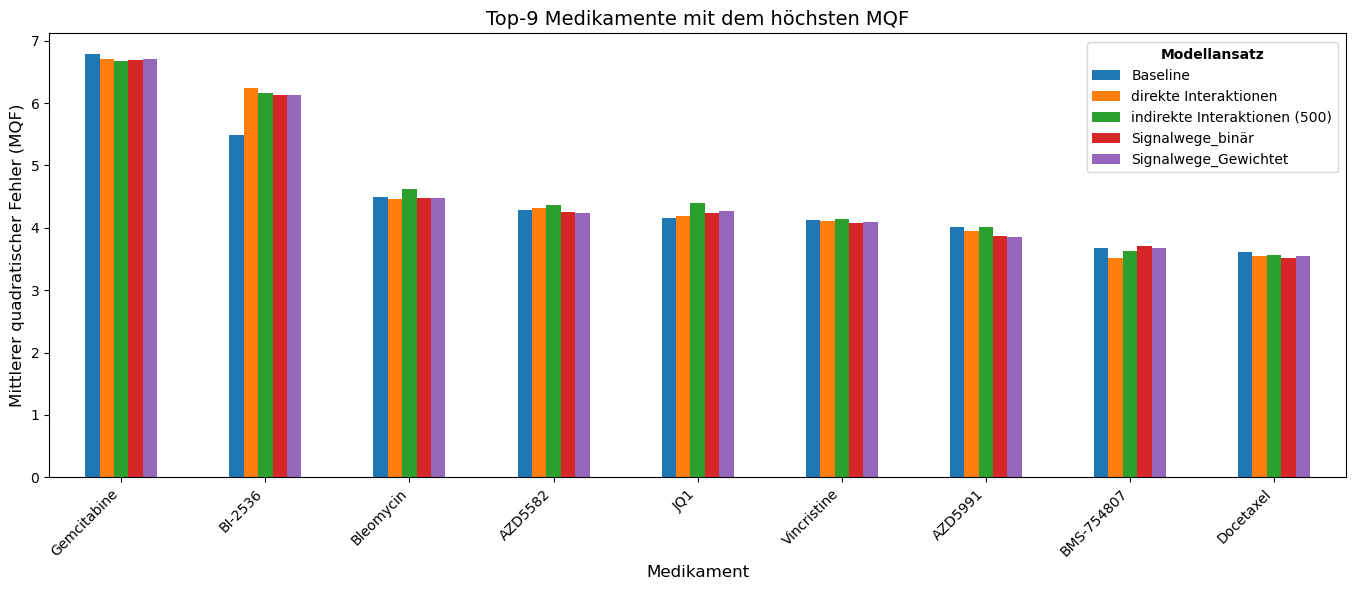

In [ ]:
# Create illustration 3.2

# Find the top N drugs with the highest MSE per approach
top_n = 10
top_drug_sets = []
for col in combined_df.columns:
    top_drugs = combined_df[col].sort_values(ascending=False).head(top_n).index
    top_drug_sets.append(set(top_drugs))

# Intersection of all top N drug sets
common_top_drugs = set.intersection(*top_drug_sets)
df_common = combined_df.loc[list(common_top_drugs)]
df_common = df_common.loc[df_common.mean(axis=1).sort_values(ascending=False).index]

# Define custom legend labels (in desired order)
custom_labels = [
    'Baseline',
    'direkte Interaktionen',
    'indirekte Interaktionen (500)',
    'Signalwege_binär',
    'Signalwege_Gewichtet'
]

# Plotting
ax = df_common.plot(kind="bar", figsize=(14, 6))
plt.title(f"Top-{top_n-1} Medikamente mit dem höchsten MQF", fontsize=14)
plt.ylabel("Mittlerer quadratischer Fehler (MQF)", fontsize=12)
plt.xlabel("Medikament", fontsize=12)
plt.xticks(rotation=45, ha="right")

legend = plt.legend(
    title="Modellansatz",
    labels=custom_labels,
    loc='upper left',                    
    bbox_to_anchor=(0.80, 0.98),        
    borderaxespad=0.,
    frameon=True,
    fontsize=10
)
legend.set_title("Modellansatz", prop={'weight': 'bold'})

plt.tight_layout()
plt.show()

### How many interactions do the drugs with the highest MSE have?

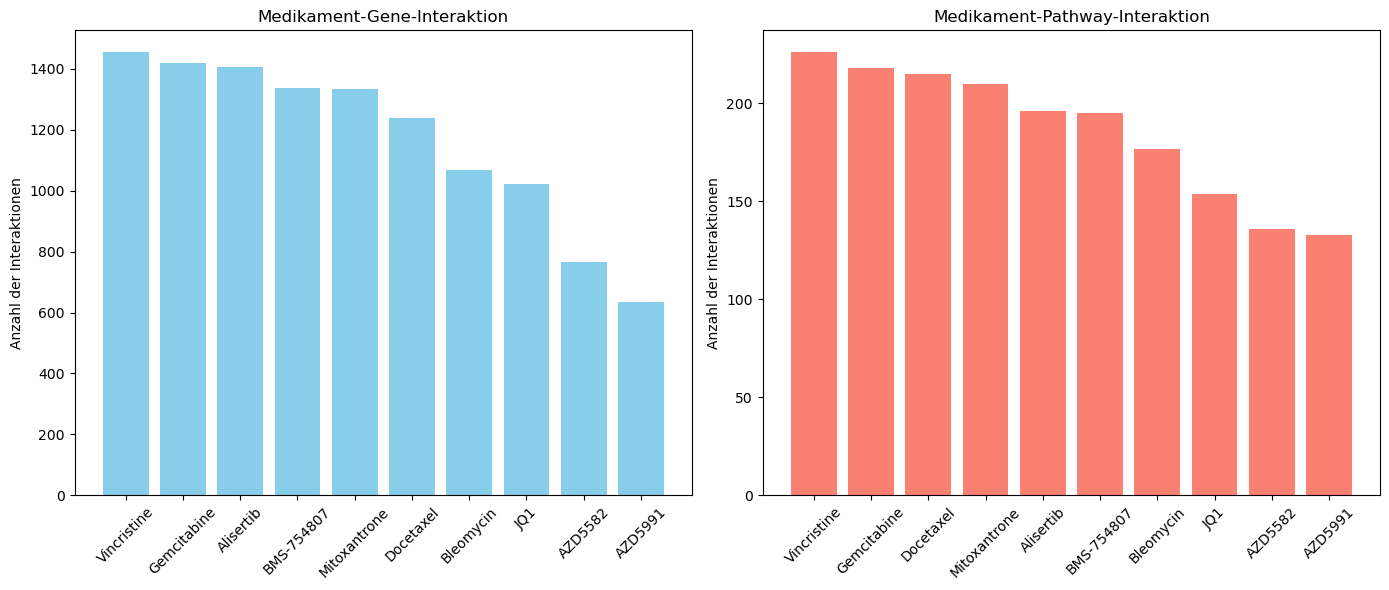

In [10]:
dgi_matrix = pd.read_csv("./data/Targets/indirect/indirect_targets_0.5.csv", index_col=0).astype(np.float32)
pathway_matrix = pd.read_csv("./data/Pathways/drug_pathway_binary_matrix.csv", index_col=0).astype(np.float32)

# Number of interactions per drug (rows)
dgi_interaction_counts = dgi_matrix.sum(axis=1)
pathway_interaction_counts = pathway_matrix.sum(axis=1)

# Drugs with hightest MSE
selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991',
                  'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin',
                  'Gemcitabine', 'Alisertib'}

# Filter the values for the selected drugs
dgi_counts_selected = dgi_interaction_counts.loc[dgi_interaction_counts.index.isin(selected_drugs)]
pathway_counts_selected = pathway_interaction_counts.loc[pathway_interaction_counts.index.isin(selected_drugs)]
dgi_counts_selected = dgi_counts_selected.sort_values(ascending=False)
pathway_counts_selected = pathway_counts_selected.sort_values(ascending=False)

# Plots erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for DGI
axes[0].bar(dgi_counts_selected.index, dgi_counts_selected.values, color='skyblue')
axes[0].set_title('Medikament-Gene-Interaktion')
axes[0].set_ylabel('Anzahl der Interaktionen')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Pathway
axes[1].bar(pathway_counts_selected.index, pathway_counts_selected.values, color='salmon')
axes[1].set_title('Medikament-Pathway-Interaktion')
axes[1].set_ylabel('Anzahl der Interaktionen')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
